In [1]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import pandas as pd

In [2]:
class FlowerClassifier(nn.Module):
    def __init__(self, num_classes=102): 
        super(FlowerClassifier, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (N, 256, 14, 14)

            nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveMaxPool2d(5, 5)  # (N, 512, 14, 14) -> (N, 512, 5, 5)
        )
        self.classifier = nn.Sequential(
            nn.Linear(in_features=5*5*512, out_features=2048),
            nn.ReLU(),
            nn.Linear(in_features=2048, out_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=num_classes)
        )
    
    def forward(self, xs):
        xs = self.cnn(xs)
        
        xs = torch.flatten(xs,start_dim=1,end_dim=-1)  # (N, 512*5*5)
        ys_logit = self.classifier(xs)
        return ys_logit



In [3]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [4]:
if __name__ == '__main__':
    model = FlowerClassifier(num_classes=102)
    print('Model parameters: ',count_parameters(model))
    xs= torch.randn(32,3,224,224)
    ys_logit = model(xs)
    print(ys_logit.shape)

Model parameters:  33315462


TypeError: flatten() received an invalid combination of arguments - got (tuple, start_dim=int, end_dim=int), but expected one of:
 * (Tensor input, int start_dim, int end_dim, name out_dim)
 * (Tensor input, int start_dim, int end_dim)
      didn't match because some of the arguments have invalid types: (!tuple of (Tensor, Tensor)!, start_dim=int, end_dim=int)
 * (Tensor input, name start_dim, name end_dim, name out_dim)
 * (Tensor input, tuple of names dims, name out_dim)
      didn't match because some of the keywords were incorrect: start_dim, end_dim


In [73]:
if __name__ == '__main__':
    transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

    #准备数据集 train, test, val
    train_set = torchvision.datasets.Flowers102(
        root=r'D:\dataset',
        split = 'train',
        transform = transform,
        download = True
    )
    test_set = torchvision.datasets.Flowers102(
        root=r'D:\dataset',
        split = 'test',
        transform = transform,
        download = True
    )

    val_set = torchvision.datasets.Flowers102(
        root=r'D:\dataset',
        split = 'val',
        transform = transform,
        download = True
    )
  

    train_dataloader = torch.utils.data.DataLoader(dataset = train_set, 
                                               batch_size = 102, 
                                               shuffle =True, #是否打乱样本
                                               num_workers =2)#子进程个数，加快进程读取
    test_dataloader = torch.utils.data.DataLoader(dataset =test_set, batch_size = 102, shuffle =True, num_workers =2)
    val_dataloader =torch.utils.data.DataLoader(dataset =val_set, batch_size = 102, shuffle =True, num_workers =2)
    
    model = FlowerClassifier(num_classes=102)
    device  ='cpu'
    model.to(device)
#初始化损失函数
    loss_ce = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(),lr = 0.001,momentum=0.9)
    # optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


#循环优化模型
num_epochs =20
train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    print('Epoch: #',epoch+1)
    running_loss = 0.0
    model.train()
    
    for xs, labels in train_dataloader:
        #注意数据tensor和model必须在同一个设备
        xs = xs.to(device)
        xs=xs.reshape(-1,224*224*3)
        labels = labels.to(device)

        ys_logit = model(xs)

        ce_loss = loss_ce(ys_logit,labels)
        running_loss += ce_loss.item()
        optimizer.zero_grad()

        ce_loss.backward()
        optimizer.step()
        train_losses.append(running_loss / len(train_dataloader))
    # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_dataloader):.4f}') 
    # print('Start validation...')
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for xs,labels in val_dataloader:
            xs = xs.to(device)
            xs=xs.reshape(-1,224*224*3)
            labels = labels.to(device)

            ys_logit = model(xs)
            pred_labels = torch.argmax(ys_logit,dim=-1)
            total +=labels.size(0)
            correct += (pred_labels==labels).sum().item()
            


        # torch.save(model.state_dict(), 'flower_classifier.pth')
    accuracy = 100 * correct / total
    val_accuracies.append(accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_dataloader):.4f},Validation Accuracy: {accuracy:.2f}%') 
   

Epoch: # 1
Epoch [1/20], Loss: 4.6241,Validation Accuracy: 5.10%
Epoch: # 2
Epoch [2/20], Loss: 4.2727,Validation Accuracy: 7.94%
Epoch: # 3
Epoch [3/20], Loss: 3.9414,Validation Accuracy: 10.29%
Epoch: # 4
Epoch [4/20], Loss: 3.6753,Validation Accuracy: 12.84%
Epoch: # 5
Epoch [5/20], Loss: 3.4490,Validation Accuracy: 13.33%
Epoch: # 6
Epoch [6/20], Loss: 3.2677,Validation Accuracy: 14.31%
Epoch: # 7
Epoch [7/20], Loss: 3.1027,Validation Accuracy: 14.80%
Epoch: # 8
Epoch [8/20], Loss: 2.9558,Validation Accuracy: 15.78%
Epoch: # 9
Epoch [9/20], Loss: 2.8177,Validation Accuracy: 15.98%
Epoch: # 10
Epoch [10/20], Loss: 2.6893,Validation Accuracy: 16.37%
Epoch: # 11
Epoch [11/20], Loss: 2.5696,Validation Accuracy: 17.25%
Epoch: # 12
Epoch [12/20], Loss: 2.4583,Validation Accuracy: 16.96%
Epoch: # 13
Epoch [13/20], Loss: 2.3511,Validation Accuracy: 17.84%
Epoch: # 14
Epoch [14/20], Loss: 2.2529,Validation Accuracy: 18.04%
Epoch: # 15
Epoch [15/20], Loss: 2.1561,Validation Accuracy: 18.53%


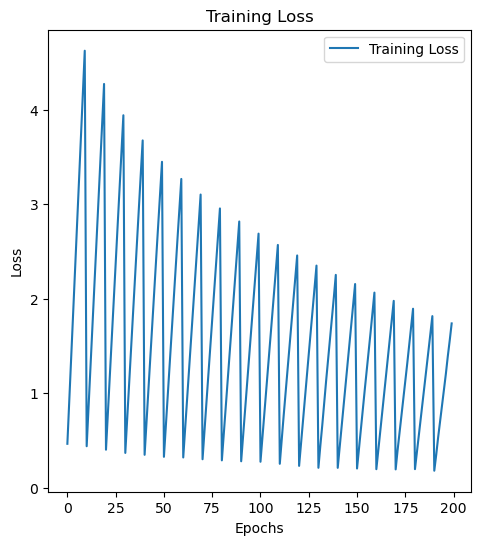

In [74]:
# 绘制损失曲线和验证集准确率曲线
plt.figure(figsize=(12, 6))

# 损失函数曲线
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

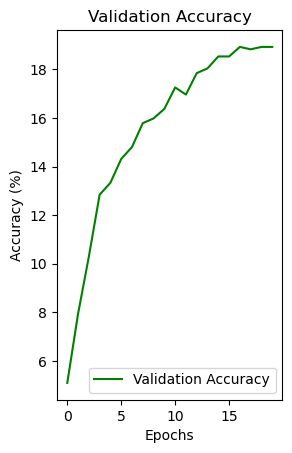

In [75]:
# 验证集准确率曲线
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy', color='green')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

In [78]:
# 评估测试集性能
def evaluate_model_on_test(model, test_dataloader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for xs, labels in test_dataloader:
            xs = xs.to(device)
            labels = labels.to(device)

            ys_logit = model(xs)
            preds = torch.argmax(ys_logit, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # 计算指标
    accuracy = accuracy_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    # AUC 需要二分类的概率，计算ROC AUC时需要得到模型对正类的预测概率
    try:
        roc_probs = nn.functional.softmax(ys_logit, dim=1)
        auc = roc_auc_score(all_labels, roc_probs[:, 1], multi_class='ovr')
    except ValueError:
        auc = "N/A"

    return accuracy, recall, f1, auc

In [79]:
test_accuracy, test_recall, test_f1, test_auc = evaluate_model_on_test(model, test_dataloader)

In [80]:
# 打印测试集指标
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")
print(f"Test AUC: {test_auc}")

Test Accuracy: 0.1576
Test Recall: 0.1576
Test F1-Score: 0.1435
Test AUC: N/A


In [81]:
# 创建表格展示结果
results = {
    'Metric': ['Accuracy', 'Recall', 'F1-Score', 'AUC'],
    'Value': [test_accuracy, test_recall, test_f1, test_auc]
}

df_results = pd.DataFrame(results)
print(df_results)

     Metric     Value
0  Accuracy  0.157587
1    Recall  0.157587
2  F1-Score   0.14354
3       AUC       N/A
